In [13]:
from pathlib import Path
from course_ocr_t1.data import MidvPackage
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [14]:
DATASET_PATH = Path() / '..' / '..'/ '..' / 'data' / 'midv500_compressed'
assert DATASET_PATH.exists(), DATASET_PATH.absolute()

In [15]:
# Собираем список пакетов (MidvPackage) 
data_packs = MidvPackage.read_midv500_dataset(DATASET_PATH)
len(data_packs), type(data_packs[0])

(50, course_ocr_t1.data.MidvPackage)

In [16]:
# В каждом пакете - 300 штук DataItem
dp = data_packs[0]
di = dp[220]
type(dp), len(dp), type(di)


(course_ocr_t1.data.MidvPackage, 300, course_ocr_t1.data.DataItem)

In [17]:
# DataItem содержит пути до файлов изображения и разметки
di.gt_path, di.img_path

(PosixPath('../../../data/midv500_compressed/33_mac_id/ground_truth/KA/KA33_18.json'),
 PosixPath('../../../data/midv500_compressed/33_mac_id/images/KA/KA33_18.png'))

In [18]:
# в gt_data (данные json) quad в абсолютных значениях (пиксели)
np.array(di.gt_data['quad'])

array([[ 48, 183],
       [403, 219],
       [382, 438],
       [ 30, 408]])

[[0.10666667 0.22875   ]
 [0.89555556 0.27375   ]
 [0.84888889 0.5475    ]
 [0.06666667 0.51      ]]


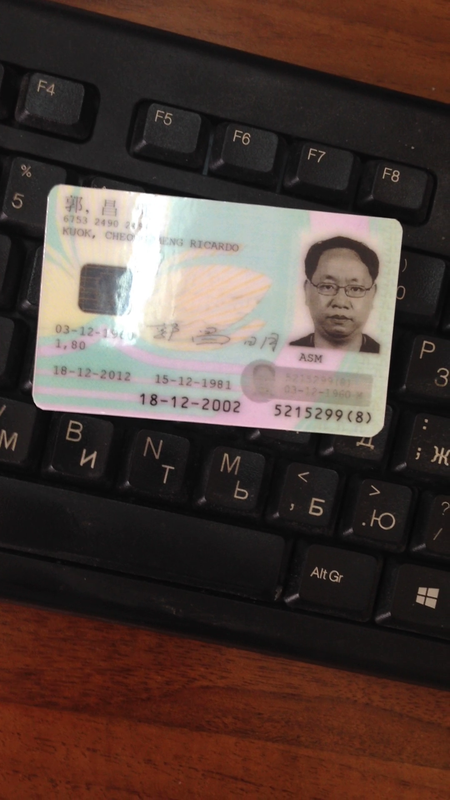

In [19]:
# Можно посмотреть изображения и разметку; в .quadrangle используются относительные единицы
print(di.quadrangle)
di.image

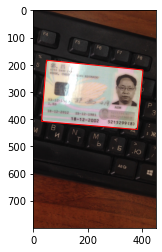

In [20]:
# Можно отрисовать разметку
# Не обязательно весь документ виден в кадре
di.show()

In [21]:
# DataItem содержит в себе информацию, относится ли он к test_split и целиком ли разметка внутри кадра
di.is_test_split(), di.is_quad_inside()

(False, True)

False


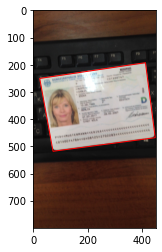

In [22]:
print(data_packs[38][238].is_test_split())
data_packs[38][238].show()

In [23]:
## Статистика, как часто разметка не целиком в кадре
is_quad_inside = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_quad_inside.append(dp[i].is_quad_inside())
is_quad_inside = np.array(is_quad_inside).astype(int)
print(f"В {is_quad_inside.sum()} из {len(is_quad_inside)} случаев разметка кропа(т.е. документ) целиком в кадре")

100%|███████████████████████████████████████████| 50/50 [00:03<00:00, 14.04it/s]

В 9992 из 15000 случаев разметка кропа(т.е. документ) целиком в кадре


In [24]:
## Статистика test-split
is_test_split = []
for dp in tqdm(data_packs):
    for i in range(len(dp)):
        is_test_split.append(dp[i].is_test_split())
is_test_split = np.array(is_test_split).astype(int)
print(f"В {is_test_split.sum()} из {len(is_test_split)} случаев кадр принадлежит к test-split")

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 374.36it/s]

В 4250 из 15000 случаев кадр принадлежит к test-split


## Classic CV baseline

### Для работы baseline нужен установленныей OpenCV 

In [25]:
import cv2
from PIL import Image
import torch
import segmentation_models_pytorch
import torchvision.transforms as tf

In [18]:
class SimpleBaselineCrop:
    """
    Baseline на основе поиска и сопоставления ключевых точек на шаблоне(ref) и запросе(query)
    Алгоритм:
        0. Найти ключевые точки(КТ) на ref
        1. Найти ключевые точки(КТ) на query
        2. Сопоставить КТ query и ref друг-другу
        3. На основе сопоставления найти гомографию из ref в query
        4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
    """
    def __init__(self, ref_image):
        self.ref_image = ref_image
        
        # 0. Найти ключевые точки(КТ) на ref
        self.ref_kpts, self.ref_fts = self.compute_kps(
            self.ref_image
        )

    def compute_kps(self, img, response_quantile=0.25):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sift = cv2.SIFT_create()
        kp = sift.detect(gray, None)
        # фильтруем 25% неуверенных точек
        q_val = np.quantile(list(k.response for k in kp), response_quantile)
        kp = [k for k in kp if k.response > q_val]
        
        kp, features = sift.compute(gray, kp)
        return kp, features 
    
    def find_qr_homography(self, kp_q, ft_q, kp_r, ft_r, ratio=0.75):
        # 2. Сопоставить КТ query и ref друг-другу
        bf = cv2.BFMatcher()
        matches = bf.knnMatch(ft_q, ft_r, k=2)
        good = []

        # Дополнителный опциональный шаг - фильтрация Lowe, Lowe ratio-test:
        # Пусть есть лучший матч1 (query-kp, ref-kp)
        # Если есть другой возможный матч2 (query-kp, ref-kp2), и их качество
        # (т.е. расстояние в пространстве features) маленькое,
        # то нельзя быть уверенном, что матч1 - надежный, и проще его выбросить
        for m,n in matches:
            if m.distance <  ratio * n.distance:
                good.append([m])
                
        ptsA = np.zeros((len(good), 2), dtype="float")
        ptsB = np.zeros((len(good), 2), dtype="float")

        for (i, mlist) in enumerate(good):
            m = mlist[0]
            ptsA[i] = kp_q[m.queryIdx].pt
            ptsB[i] = kp_r[m.trainIdx].pt
        # 3. На основе сопоставления найти гомографию из ref в query
        (H, mask) = cv2.findHomography(ptsB, ptsA, method=cv2.RANSAC)
        return H
              
    def compute_crop(self, ref_img, hmg):
        # 4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
        h, w, _ = ref_img.shape
        h = float(h)
        w = float(w)
        points = [
            [0, 0],
            [w, 0],
            [w, h],
            [0, h],
        ]
        points_crop = []
        for p in points:
            # применяем гомографию к точке, представленной в гомогенных координатах
            vec = hmg @ np.array([p[0], p[1], 1])
            points_crop.append([vec[0]/vec[-1], vec[1]/vec[-1]])
        return np.array(points_crop)
        
    def __call__(self, query_image):
        # 1. Найти ключевые точки(КТ) на query
        kpts, fts = self.compute_kps(query_image)
        
        homography = self.find_qr_homography(
            kpts, fts, self.ref_kpts, self.ref_fts
        )
        abs_crop = self.compute_crop(self.ref_image, homography)
        h, w, _ = query_image.shape
        rel_crop = abs_crop / np.array([[w, h]])
        return rel_crop

In [47]:
class UNetCrop:
    """
    Baseline на основе поиска и сопоставления ключевых точек на шаблоне(ref) и запросе(query)
    Алгоритм:
        0. Найти ключевые точки(КТ) на ref
        1. Найти ключевые точки(КТ) на query
        2. Сопоставить КТ query и ref друг-другу
        3. На основе сопоставления найти гомографию из ref в query
        4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
    """
    def __init__(self, ref_image):
        self.ref_image = ref_image
        
        self.transformImg=tf.Compose([tf.Resize((256, 128)),tf.ToTensor(),tf.Normalize((0.485, 0.456, 0.406), 
                                                                                       (0.229, 0.224, 0.225))])

        self.model = segmentation_models_pytorch.UnetPlusPlus(in_channels=3, classes=1)
        self.model.load_state_dict(torch.load("unet_plus_plus_500.torch"))
        
        self.model.to(torch.device('cpu'))
        self.model.eval()
  
        
    def get_model_mask(self, input_image):
        
        cur_image = self.transformImg(Image.fromarray(input_image))
        cur_image = torch.autograd.Variable(cur_image, requires_grad=False).to(torch.device('cpu')).unsqueeze(0)

        with torch.no_grad():
            model_preds = torch.nn.functional.sigmoid(self.model(cur_image))

        model_preds = tf.Resize((input_image.shape[0], input_image.shape[1]))(model_preds[0])
        
        model_preds = model_preds.detach().cpu().numpy() > 0.5
        
        return model_preds.astype(np.uint8)[0]
    
    
    def get_area(self, binarized_map):
        contours, _ = cv2.findContours(binarized_map, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    
        max_S = -1
        best_area = None

        for cnt in contours:
            area = cv2.contourArea(cnt)
            if area > max_S:
                epsilon = 0.1 * cv2.arcLength(cnt, True)
                max_S = area
                best_area = cv2.approxPolyDP(cnt, epsilon, True)
    
        best_area = [i[0] for i in best_area]
    
        if len(best_area) != 4:
            best_area = None
            max_S = -1
            for i, c in enumerate(contours):
                rect = cv2.minAreaRect(c)
                w, h = rect[1]
                if w * h > max_S:
                    best_area = cv2.boxPoints(rect)
                    best_area = np.int0(best_area)
                    max_S = w * h
                
        return best_area
    

#     def compute_kps(self, img, response_quantile=0.25):
#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#         sift = cv2.SIFT_create()
#         kp = sift.detect(gray, None)
#         # фильтруем 25% неуверенных точек
#         q_val = np.quantile(list(k.response for k in kp), response_quantile)
#         kp = [k for k in kp if k.response > q_val]
        
#         kp, features = sift.compute(gray, kp)
#         return kp, features 
    
#     def find_qr_homography(self, kp_q, ft_q, kp_r, ft_r, ratio=0.75):
#         # 2. Сопоставить КТ query и ref друг-другу
#         bf = cv2.BFMatcher()
#         matches = bf.knnMatch(ft_q, ft_r, k=2)
#         good = []

#         # Дополнителный опциональный шаг - фильтрация Lowe, Lowe ratio-test:
#         # Пусть есть лучший матч1 (query-kp, ref-kp)
#         # Если есть другой возможный матч2 (query-kp, ref-kp2), и их качество
#         # (т.е. расстояние в пространстве features) маленькое,
#         # то нельзя быть уверенном, что матч1 - надежный, и проще его выбросить
#         for m,n in matches:
#             if m.distance <  ratio * n.distance:
#                 good.append([m])
                
#         ptsA = np.zeros((len(good), 2), dtype="float")
#         ptsB = np.zeros((len(good), 2), dtype="float")

#         for (i, mlist) in enumerate(good):
#             m = mlist[0]
#             ptsA[i] = kp_q[m.queryIdx].pt
#             ptsB[i] = kp_r[m.trainIdx].pt
#         # 3. На основе сопоставления найти гомографию из ref в query
#         (H, mask) = cv2.findHomography(ptsB, ptsA, method=cv2.RANSAC)
#         return H
              
#     def compute_crop(self, ref_img, hmg):
#         # 4. Отобразить 4 угла изображения ref в query - это искомый четырехугольник кропа
#         h, w, _ = ref_img.shape
#         h = float(h)
#         w = float(w)
#         points = [
#             [0, 0],
#             [w, 0],
#             [w, h],
#             [0, h],
#         ]
#         points_crop = []
#         for p in points:
#             # применяем гомографию к точке, представленной в гомогенных координатах
#             vec = hmg @ np.array([p[0], p[1], 1])
#             points_crop.append([vec[0]/vec[-1], vec[1]/vec[-1]])
#         return np.array(points_crop)
        
    def __call__(self, query_image):
        # 1. Найти ключевые точки(КТ) на query
        
#         kpts, fts = self.compute_kps(query_image)
        
#         homography = self.find_qr_homography(
#             kpts, fts, self.ref_kpts, self.ref_fts
#         )
#         abs_crop = self.compute_crop(self.ref_image, homography)

        model_mask = self.get_model_mask(query_image)
        
        abs_crop = self.get_area(model_mask)
        h, w, _ = query_image.shape
        rel_crop = abs_crop / np.array([[w, h]])
        return rel_crop

In [48]:
#bcm = SimpleBaselineCrop(np.array(dp.template_item.image))
bcm = UNetCrop(np.array(dp.template_item.image))

In [49]:
pred_quad = bcm(np.array(dp[0].image))

In [50]:
pred_quad, dp[0].quadrangle

(array([[0.13555556, 0.3175    ],
        [0.26      , 0.62125   ],
        [0.94444444, 0.6325    ],
        [0.96666667, 0.325     ]]),
 array([[0.12666667, 0.3125    ],
        [0.97555556, 0.31625   ],
        [0.94888889, 0.64      ],
        [0.14888889, 0.62875   ]]))

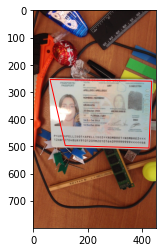

In [51]:
dp[0].show(pred_quad)

In [53]:
results_dict = dict()

for dp in tqdm(data_packs):
    bcm = UNetCrop(np.array(dp.template_item.image))
    for i in range(len(dp)):
        if dp[i].is_test_split():
            try:
                results_dict[dp[i].unique_key] = bcm(np.array(dp[i].image))
            except Exception as exc:
                # Для пропущенных в словаре ключей в метриках автоаматически засчитается IoU=0
                print(exc)


  2%|▉                                           | 1/50 [00:25<20:59, 25.71s/it]

'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable


 42%|██████████████████                         | 21/50 [17:19<35:00, 72.44s/it]

'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable
'NoneType' object is not iterable


100%|███████████████████████████████████████████| 50/50 [35:57<00:00, 43.16s/it]


### Сохраним результаты и измерим точность
Результаты - словарь с ключем DataItem.unique_key() и значением предсказанным quadrangle в относительных единицах.

In [54]:
from course_ocr_t1.metrics import dump_results_dict, measure_crop_accuracy

In [55]:
dump_results_dict(results_dict, Path() / 'pred.json')

In [56]:
acc = measure_crop_accuracy(
    Path() / 'pred.json',
    Path() / 'gt.json'
)

In [57]:
print("Точность кропа: {:1.4f}".format(acc))

Точность кропа: 0.0534
